# Frontal Face Detector 

정면 얼굴 검출기

## 의존성 패키지 설치

OpenCV for Python

https://opencv.org/

* opencv-python: 메인 모듈
* opencv-contrib-python: 확장 모듈

C++ Tookit for Machine Learning

http://dlib.net/


In [ ]:
# 설치
!pip install -q --upgrade pip
!pip install -q opencv-python opencv-contrib-python
!pip install -q dlib

In [8]:
from IPython.display import clear_output, Image, display
import cv2, time, dlib
import numpy as np

curr_time = 0

def getFPS():
    global curr_time
    if curr_time == 0:
        curr_time = time.time()
        fps = 0
    else:
        last_time = curr_time
        curr_time = time.time()
        fps = 1. / (curr_time - last_time)
    return fps

def putText(frame, text):
    height, width, _ = frame.shape
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    org = (0, height - 10)
    font_color = (255, 0, 0)
    thickness = 2
    cv2.putText(frame, text, org, font, font_scale, font_color, thickness)
    return frame

def resize(frame, scale=0.2):
    height, width, _ = frame.shape
    frame = cv2.resize(frame, (int(width * scale), int(height * scale)))
    return frame

def drawFaceRectangle(frame, face):
    pt1 = (face.left(), face.top())
    pt2 = (face.right(), face.bottom())
    color = (255, 0, 0)
    thickness = 2
    line_type = cv2.LINE_AA
    frame = cv2.rectangle(frame, pt1, pt2, color, thickness, line_type)
    return frame

def drawFaceShape(frame, shape):
    shape_2d = np.array([[p.x, p.y] for p in shape.parts()])
    radius=1
    color=(255, 0, 0)
    thickness=2
    line_type=cv2.LINE_AA
    for s in shape_2d:
        center=tuple(s)        
        cv2.circle(frame, center, radius, color, thickness, line_type)
    return frame
    
def getImage(frame):
    ret, png = cv2.imencode('.png', frame)
    return Image(png)

# overlay function
# https://gist.github.com/clungzta/b57163b165d3247af2ebfe2868f7dccf
def overlay_transparent(background_img, img_to_overlay_t, x, y, overlay_size=None):
    """
    @brief      Overlays a transparant PNG onto another image using CV2
    
    @param      background_img    The background image
    @param      img_to_overlay_t  The transparent image to overlay (has alpha channel)
    @param      x                 x location to place the top-left corner of our overlay
    @param      y                 y location to place the top-left corner of our overlay
    @param      overlay_size      The size to scale our overlay to (tuple), no scaling if None
    
    @return     Background image with overlay on top
    """
    
    bg_img = background_img.copy()
    # convert 3 channels to 4 channels
    if bg_img.shape[2] == 3:
        bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2BGRA)
    
    if overlay_size is not None:
        img_to_overlay_t = cv2.resize(img_to_overlay_t.copy(), overlay_size)

    # Extract the alpha mask of the RGBA image, convert to RGB 
    b,g,r,a = cv2.split(img_to_overlay_t)
    overlay_color = cv2.merge((b,g,r))
    #print(overlay_color.shape)
    
    # Optional, apply some simple filtering to the mask to remove edge noise
    mask = cv2.medianBlur(a,5)

    h, w, _ = overlay_color.shape

    x, y = int(x-(float(w)/2.0)), int((y-float(h)/2.0))
    roi = bg_img[y:y+h, x:x+w]

    #print(h,w)
    #print('x y: ', x,y)
    #print(roi.shape, mask.shape)

    # Black-out the area behind the logo in our original ROI
    img1_bg = cv2.bitwise_and(roi,roi,mask = cv2.bitwise_not(mask))
    
    # Mask out the logo from the logo image.
    img2_fg = cv2.bitwise_and(overlay_color,overlay_color,mask = mask)

    # Update the original image with our new ROI
    bg_img[y:y+h, x:x+w] = cv2.add(img1_bg, img2_fg)
    return bg_img

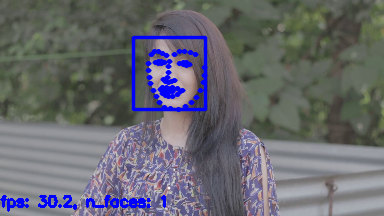

In [11]:
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

video = cv2.VideoCapture("./girl.mp4")
overlay = cv2.imread('./ryan_transparent.png', cv2.IMREAD_UNCHANGED)

fidx = 0
while(True):
    try:
        clear_output(wait=True)
        ret, frame = video.read()
        if not ret:
            break
        fidx += 1
        frame = resize(frame, 0.2)
        
        faces = face_detector(frame)
        n_faces = len(faces)
        
        for face in faces:
            frame = drawFaceRectangle(frame, face)
        
            face_shape = shape_predictor(frame, face)
            frame = drawFaceShape(frame, face_shape)
        
            # compute face center
            shape_2d = np.array([[p.x, p.y] for p in face_shape.parts()])            
            center_x, center_y = np.mean(shape_2d, axis=0).astype(np.int)
            # compute face boundaries
            min_coords = np.min(shape_2d, axis=0)
            max_coords = np.max(shape_2d, axis=0)
            # compute face size
            face_size = int(max(max_coords - min_coords) * 1.5)
        
            #frame = overlay_transparent(frame, overlay, center_x, center_y, overlay_size=(face_size, face_size))
        
        fps = getFPS()
        text = f"fps: {fps:.1f}, n_faces: {n_faces}"
        frame = putText(frame, text)
        
        img = getImage(frame)
        display(img)        
        #time.sleep(0.001)
    except KeyboardInterrupt:
        # KeyboardInterrupt 를 raise 하기 위해서는 I 키를 두번 누름 
        video.release()